In [2]:
def get_all_newforms_at_level(level, expansion_terms=30, output_file=None):
    """
    Get ALL weight 2 rational newforms at a specific level.
    Only takes one curve per isogeny class (since they give the same newform).
    """
    from sage.databases.cremona import CremonaDatabase
    import time
    
    start_time = time.time()
    db = CremonaDatabase()
    
    rational_forms = []
    
    print(f"Weight 2 rational newforms at level {level}")
    print(f"Computing {expansion_terms} terms\n")
    
    # Open output file if specified
    if output_file:
        f_out = open(output_file, 'w')
    
    try:
        curves = db.allcurves(level)
        
        if curves:
            # Group by isogeny class (the letter part)
            isogeny_classes = {}
            for label in curves.keys():
                # Extract the letter (isogeny class identifier)
                letter = ''.join([c for c in label if c.isalpha()])
                if letter not in isogeny_classes:
                    isogeny_classes[letter] = label
            
            print(f"Found {len(isogeny_classes)} distinct newforms (isogeny classes)\n")
            
            # Process one curve per isogeny class
            for letter in sorted(isogeny_classes.keys()):
                label = isogeny_classes[letter]
                full_label = f"{level}{label}"
                E = EllipticCurve(full_label)
                rational_forms.append((level, 2, E))
                
                # Print header to console
                print(f"\n{'='*70}")
                print(f"Newform {len(rational_forms)}: Isogeny class {level}{letter}")
                print(f"Representative curve: {full_label}")
                print(f"{'='*70}")
                
                # Get coefficients
                an_list = E.anlist(expansion_terms + 1)
                coeffs = an_list[1:]
                
                # Write to file
                if output_file:
                    f_out.write(f"Isogeny class: {level}{letter}\n")
                    f_out.write(f"Representative curve: {full_label}\n")
                    f_out.write(f"Coefficients a_1 to a_{expansion_terms}:\n")
                    f_out.write(str(coeffs) + "\n\n")
                
                # Show first 10 coefficients to console
                print(f"Coefficients (first 10 of {expansion_terms}):")
                print(f"  a_1-a_10: {coeffs[:10]}")
                
                # Additional info
                print(f"\nCurve info:")
                print(f"  Conductor: {E.conductor()}")
                print(f"  Rank: {E.rank()}")
                
                if output_file:
                    f_out.write(f"Conductor: {E.conductor()}\n")
                    f_out.write(f"Rank: {E.rank()}\n")
                    f_out.write(f"{'='*70}\n\n")
    
    except Exception as e:
        print(f"Error at level {level}: {e}")
    
    if output_file:
        f_out.close()
        print(f"\nFull data written to: {output_file}")
    
    elapsed = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"Found {len(rational_forms)} distinct newforms in {elapsed:.2f} seconds")
    print(f"{'='*70}")
    
    return rational_forms


results = get_all_newforms_at_level(
    level=43,
    expansion_terms=1300,
    output_file="/Users/barrybrent/data2/run1feb26no13.txt"
)

Weight 2 rational newforms at level 43
Computing 1300 terms

Found 1 distinct newforms (isogeny classes)


Newform 1: Isogeny class 43a
Representative curve: 43a1
Coefficients (first 10 of 1300):
  a_1-a_10: [1, -2, -2, 2, -4, 4, 0, 0, 1, 8]

Curve info:
  Conductor: 43
  Rank: 1

Full data written to: /Users/barrybrent/data2/run1feb26no13.txt

Found 1 distinct newforms in 0.06 seconds


In [7]:
# loads all forms at a given level one at a time converted to lists
def load_newforms_from_file(filename):
    """
    Load all newforms from a file and return them as a list of dictionaries.
    Each dictionary contains the label and coefficients.
    """
    with open(filename, 'r') as f:
        content = f.read()
    
    # Split by the separator line
    blocks = content.split('='*70)
    
    newforms = []
    
    for block in blocks:
        if 'Isogeny class:' in block:
            lines = block.strip().split('\n')
            
            # Extract isogeny class
            isogeny_class = lines[0].replace('Isogeny class:', '').strip()
            
            # Extract representative curve
            rep_curve = lines[1].replace('Representative curve:', '').strip()
            
            # Find the coefficients line
            for i, line in enumerate(lines):
                if line.startswith('['):
                    coeffs = eval(line)
                    break
            
            newforms.append({
                'isogeny_class': isogeny_class,
                'representative': rep_curve,
                'coefficients': coeffs
            })
    
    return newforms

# Load all newforms
newforms = load_newforms_from_file("/Users/barrybrent/data2/run1feb26no13.txt")

print(f"Loaded {len(newforms)} newforms\n")
print("number of newforms:",len(newforms))
# Access them one at a time
for i, form in enumerate(newforms):
    print(f"Newform {i+1}:")
    print(f"  Isogeny class: {form['isogeny_class']}")
    print(f"  Representative: {form['representative']}")
    print(f"  First 10 coefficients: {form['coefficients'][:10]}")
    print(f"  Total coefficients: {len(form['coefficients'])}")
    print()

# Access individual newforms
newform_1 = newforms[0]['coefficients']  # First newform
#newform_2 = newforms[1]['coefficients']  # Second newform (if it exists)

print(f"Newform 1, coefficient of q^5: {newform_1[4]}")  # Remember: index 4 is a_5
print(newform_1[:10])

Loaded 1 newforms

number of newforms: 1
Newform 1:
  Isogeny class: 43a
  Representative: 43a1
  First 10 coefficients: [1, -2, -2, 2, -4, 4, 0, 0, 1, 8]
  Total coefficients: 1301

Newform 1, coefficient of q^5: -4
[1, -2, -2, 2, -4, 4, 0, 0, 1, 8]


In [8]:
from sage.all import sigma, nth_prime
from sage.arith.all import moebius
import pickle
import ast


def load_newforms_from_file(filename):
    """
    Load all newforms from a file and return them as a list of dictionaries.
    Each dictionary contains the label and coefficients.
    """
    with open(filename, 'r') as f:
        content = f.read()
    
    # Split by the separator line
    blocks = content.split('='*70)
    
    newforms = []
    
    for block in blocks:
        if 'Isogeny class:' in block:
            lines = block.strip().split('\n')
            
            # Extract isogeny class
            isogeny_class = lines[0].replace('Isogeny class:', '').strip()
            
            # Extract representative curve
            rep_curve = lines[1].replace('Representative curve:', '').strip()
            
            # Find the coefficients line
            for i, line in enumerate(lines):
                if line.startswith('['):
                    coeffs = eval(line)
                    break
            
            newforms.append({
                'isogeny_class': isogeny_class,
                'representative': rep_curve,
                'coefficients': coeffs
            })
    
    return newforms

# Load all newforms
newforms = load_newforms_from_file("/Users/barrybrent/data2/run1feb26no13.txt")

print(f"Loaded {len(newforms)} newforms\n")
print("number of newforms:",len(newforms))
# Access them one at a time
for i, form in enumerate(newforms):
    print(f"Newform {i+1}:")
    print(f"  Isogeny class: {form['isogeny_class']}")
    print(f"  Representative: {form['representative']}")
    print(f"  First 10 coefficients: {form['coefficients'][:10]}")
    print(f"  Total coefficients: {len(form['coefficients'])}")
    print()

# Access individual newforms
newform_1 = newforms[0]['coefficients']  # First newform
#newform_2 = newforms[1]['coefficients']  # Second newform (if it exists)

print(f"Newform 1, coefficient of q^5: {newform_1[4]}")  # Remember: index 4 is a_5
print(newform_1[:10])

h_list=[1]+newform_1 # h_0 = 1 required by the lemmas
j_list=[(0,1)] # first entry is just an offset. 
for n in [1..500]:# so j(1) = 1 = h(0) as required.
    sm=0
    for r in [1..n-1]: 
        sm=sm+j_list[r][1]*h_list[n-r] 
    j_n=n*h_list[n]-sm
    print((n,j_n))
    j_list.append((n,j_n))
    
with open('/Users/barrybrent/data2/run1feb26no14.txt', 'wb') as wfile:
    pickle.dump(j_list, wfile) 

Loaded 1 newforms

number of newforms: 1
Newform 1:
  Isogeny class: 43a
  Representative: 43a1
  First 10 coefficients: [1, -2, -2, 2, -4, 4, 0, 0, 1, 8]
  Total coefficients: 1301

Newform 1, coefficient of q^5: -4
[1, -2, -2, 2, -4, 4, 0, 0, 1, 8]
(1, 1)
(2, -5)
(3, 1)
(4, -1)
(5, -29)
(6, 67)
(7, -153)
(8, 255)
(9, -368)
(10, 405)
(11, 89)
(12, -1417)
(13, 4720)
(14, -10659)
(15, 20446)
(16, -31121)
(17, 35871)
(18, -12506)
(19, -78944)
(20, 310429)
(21, -772701)
(22, 1536013)
(23, -2519166)
(24, 3208167)
(25, -2164329)
(26, -3728704)
(27, 19948393)
(28, -54363023)
(29, 114483852)
(30, -198880488)
(31, 276607514)
(32, -248940145)
(33, -110814010)
(34, 1226210539)
(35, -3746007658)
(36, 8400165782)
(37, -15421196218)
(38, 23088573610)
(39, -24815703431)
(40, 4340955365)
(41, 70473055247)
(42, -252001448415)
(43, 606300143449)
(44, -1176050245371)
(45, 1878414411427)
(46, -2288315942436)
(47, 1259534654256)
(48, 3607318055239)
(49, -16455704755559)
(50, 43001096517105)
(51, -88268819

In [9]:
import pickle
from sage.all import sigma, nth_prime
import ast


with open('/Users/barrybrent/data2/run1feb26no14.txt', 'rb') as rfile:
    j_list = pickle.load(rfile)
    
def P_matrix(lst):
    lenlist=len(lst)
    columns=[lst]
    for k in range(1,lenlist):
        column=[0]*(k-1)
        column=column+[-k]
        column=flatten(column+[lst])
        column=column+[lst]
        column=column[:lenlist]
        columns+=[column]
    return (matrix(columns)).transpose()

from sage.all import *
precision_bits = 100
CC = ComplexField(precision_bits)
x = polygen(QQ)  # Can remain in preamble if all polynomials are in one variable

charpol_list=[]
roots_list=[]

mins_list=[]
log_mins_list=[]

dets=[]

for n in range(1, 401):
    print(n)
    deformed_j_list=j_list[:n]
    inputs=[pair[1] for pair in deformed_j_list]
    pl=P_matrix(inputs) 
    det=pl.det()
    dets.append((n,det))
    cp=pl.charpoly()
    charpol_list.append((n,cp))
    roots = cp.roots(ring=CC, multiplicities=False)       
    roots_list.append((n,roots))
    aar = [r.abs() for r in roots]
    if aar!=[]:
        minn = min(aar)  
        mins_list.append((n,minn))
        if minn>0:
            log_minn=log(minn)
            log_mins_list.append((n,log_minn))
        



p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOGS MINIMUM MODULI")
p.show()


with open('/Users/barrybrent/data2/run1feb2626no15.txt', 'wb') as wfile:
    pickle.dump(roots_list, wfile) #output snipped

with open('/Users/barrybrent/data2/run1feb26no16.txt', 'wb') as wfile:
    pickle.dump(charpol_list, wfile) #output snipped

with open('/Users/barrybrent/data2/run1feb26no17.txt', 'wb') as wfile:
    pickle.dump(dets, wfile) #output snipped
    
with open('/Users/barrybrent/data2/run1feb2626no18.txt', 'wb') as wfile:
    pickle.dump(log_mins_list, wfile) #output snipped

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

Data range: n = 1 to 387
Number of data points: 387
Min modulus range: 0.016092 to 7.008609
Log min modulus range: -4.129414 to 1.947139

Polynomial trend coefficients: [-5.64993483e-06  2.40621295e-03  7.36528638e-01]
Detrended data std dev: 0.9624

TOP DOMINANT PERIODICITIES (in index n)
Rank   Period       Frequency    Power          
----------------------------------------------------------------------
1            7.30     0.136951       4.49e+04
2            3.65     0.273902       5.34e+03
3            2.43     0.410853       2.61e+03


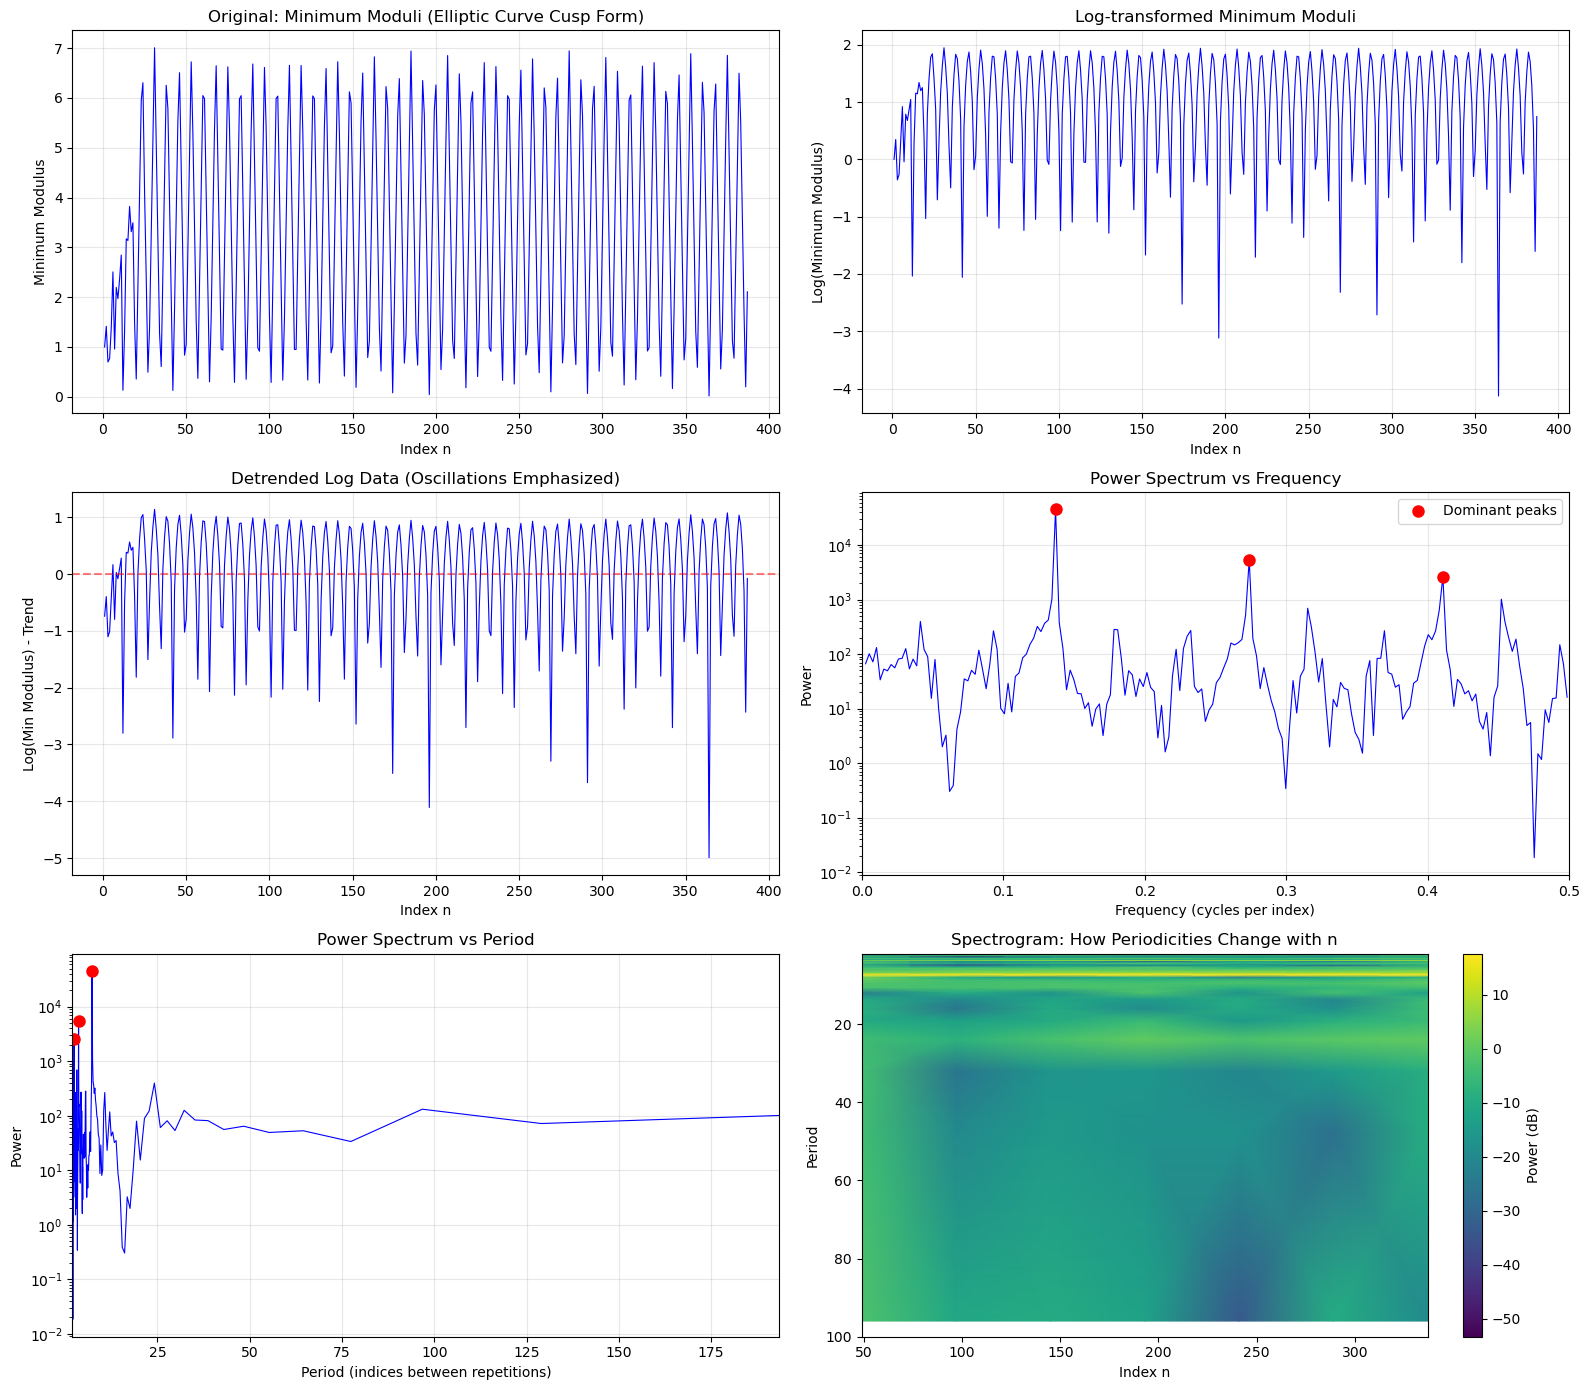


SIGNAL RECONSTRUCTION (using top 5 frequencies)
Component 1: Period = 7.30, Amplitude = 0.0826
Component 2: Period = 3.65, Amplitude = 0.0585
Component 3: Period = 2.43, Amplitude = 0.0650


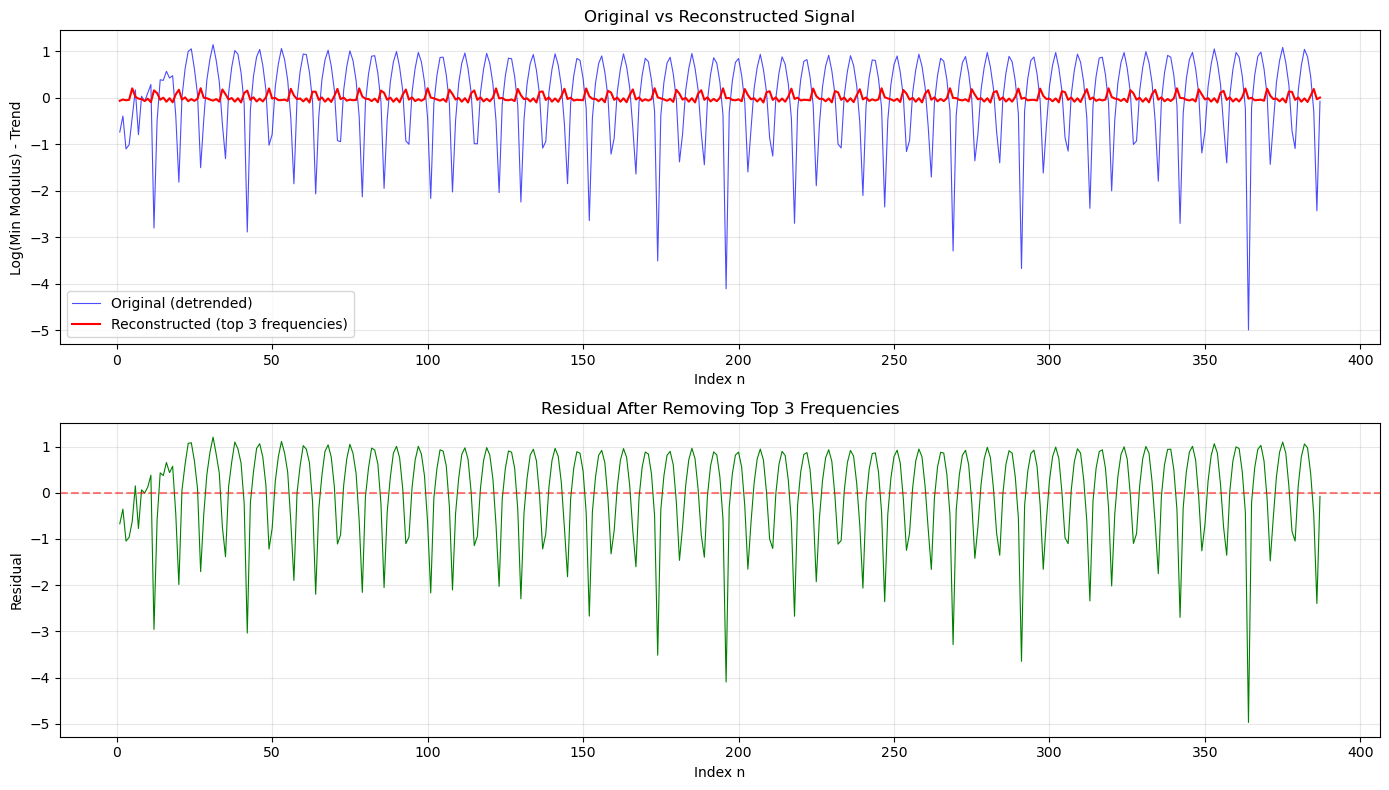


Analysis complete! Examine the plots and frequency table above.


In [14]:
with open('/Users/barrybrent/data2/run1feb2626no19.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile) #output snipped

# FOURIER ANALYSIS OF MINIMUM MODULI - Elliptic Curve Cusp Form
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
min_moduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Also prepare the log-transformed data
log_min_moduli = np.log(min_moduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {min_moduli.min():.6f} to {min_moduli.max():.6f}")
print(f"Log min modulus range: {log_min_moduli.min():.6f} to {log_min_moduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(log_min_moduli, type='linear')

# Polynomial detrend (degree 2) - captures parabolic growth
poly_coeffs = np.polyfit(indices, log_min_moduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = log_min_moduli - poly_trend

print(f"\nPolynomial trend coefficients: {poly_coeffs}")
print(f"Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find peaks in the power spectrum
# Lower threshold to catch more peaks since we have more data (n up to 400)
peak_indices = signal.find_peaks(power, height=np.max(power)*0.05)[0]  # peaks at least 5% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(15, len(sorted_indices))]  # Show top 15

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f}   {freq:>10.6f}   {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, min_moduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli (Elliptic Curve Cusp Form)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, log_min_moduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('Log(Min Modulus) - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]], 
                     peak_powers[top_peaks], 'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
# Only plot periods up to half the data length (longer periods unreliable)
max_period = len(indices) / 2
period_mask = periods <= max_period
axes[2, 0].semilogy(periods[period_mask], power[period_mask], 'b-', linewidth=0.8)
# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] <= max_period:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx], 'ro', markersize=8)
axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, max_period)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(128, len(indices)//4)  # adaptive window size, larger for more data
f_spec, t_spec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0, 
                                          nperseg=window_size, 
                                          noverlap=window_size//2)
# Convert frequency axis to period for easier interpretation
period_spec = 1.0 / (f_spec + 1e-10)  # avoid division by zero
period_spec = period_spec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis (inverted so small periods at bottom)
im = axes[2, 1].pcolormesh(indices[0] + t_spec, period_spec, 10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, max_period))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

# ==============================================================================
# 6. FILTERED SIGNAL (reconstruct using only dominant frequencies)
# ==============================================================================

# Reconstruct signal using only the top 5 dominant frequencies
# This shows what the "pure" oscillatory pattern looks like

print("\n" + "="*70)
print("SIGNAL RECONSTRUCTION (using top 5 frequencies)")
print("="*70)

reconstructed = np.zeros_like(log_detrended_poly)
num_components = min(5, len(top_peaks))
for rank, idx in enumerate(top_peaks[:num_components], 1):  
    freq = frequencies[peak_indices[idx]]
    period = peak_periods[idx]
    # Get amplitude and phase from FFT
    amp = np.abs(fft_result[peak_indices[idx]]) / len(indices)
    phase = np.angle(fft_result[peak_indices[idx]])
    # Reconstruct this component
    component = amp * np.cos(2 * np.pi * freq * indices + phase)
    reconstructed += component
    print(f"Component {rank}: Period = {period:.2f}, Amplitude = {amp:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8, alpha=0.7, label='Original (detrended)')
axes[0].plot(indices, reconstructed, 'r-', linewidth=1.5, label=f'Reconstructed (top {num_components} frequencies)')
axes[0].set_xlabel('Index n')
axes[0].set_ylabel('Log(Min Modulus) - Trend')
axes[0].set_title('Original vs Reconstructed Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual (what's left after removing dominant frequencies)
residual = log_detrended_poly - reconstructed
axes[1].plot(indices, residual, 'g-', linewidth=0.8)
axes[1].set_xlabel('Index n')
axes[1].set_ylabel('Residual')
axes[1].set_title(f'Residual After Removing Top {num_components} Frequencies')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)

MINIMUM MODULI


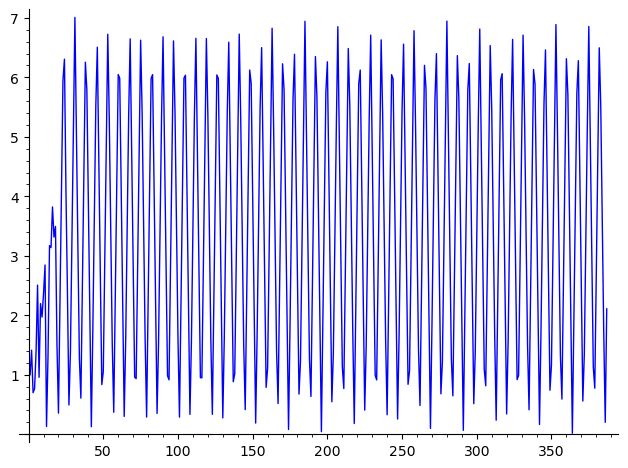

In [2]:
import pickle
with open('/Users/barrybrent/data2/run1feb2626no19.txt', 'rb') as rfile:
    mins_list = pickle.load(rfile)

p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()